In [2]:
import torch
from torch import nn
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor

In [3]:
vgg_model = vgg16()

In [4]:
to_tensor_transform = ToTensor()

In [85]:
# 224x224 input size
style_image = Image.open('./data/style_transfer/starry_night.jpg')
content_image = Image.open('./data/style_transfer/yi_long_ma.jpg')

style_image = style_image.resize((224, 224))
content_image = content_image.resize((224, 224))

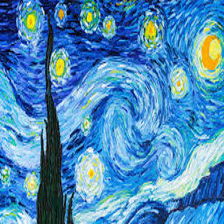

In [86]:
style_image

In [87]:
style_image = to_tensor_transform(style_image)
content_image = to_tensor_transform(content_image)

In [6]:
vgg_model.features[:30]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

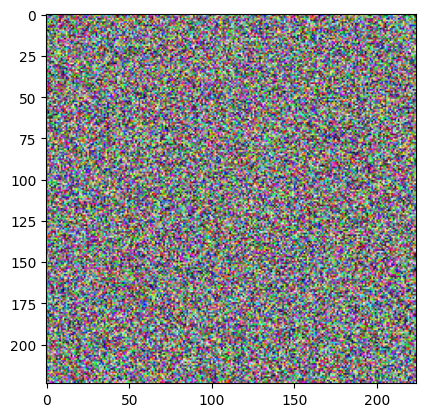

In [199]:
# content replication
noise = torch.rand((3, 224, 224))
noise.requires_grad = True
plt.imshow(noise.permute(1,2,0).detach().numpy())

In [8]:
# content? 
content_feature_output = vgg_model.features[:11](content_image)

In [151]:
averaged_fortnite = content_feature_output.mean(dim=0).detach()

In [215]:
noise_feature_output.shape, averaged_fortnite.shape

(torch.Size([56, 56]), torch.Size([56, 56]))

In [216]:
for i in range(25):
    vgg_model.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:10](noise).mean(dim=0)
    content_loss = ((noise_feature_output - averaged_fortnite)**2).sum()
    content_loss.backward()
    with torch.no_grad():
        print(content_loss, torch.norm(noise.grad), "                ", end="\r")
        noise = noise - noise.grad * 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


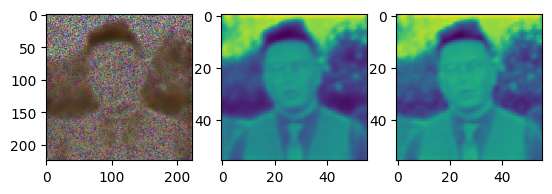

In [217]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(noise.detach().permute(1,2,0).numpy())
axs[1].imshow(noise_feature_output.detach().numpy())
axs[2].imshow(averaged_fortnite.detach().numpy())

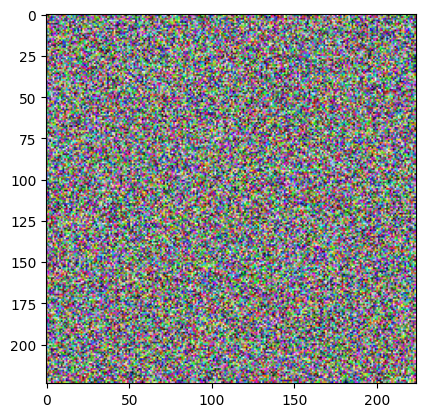

In [157]:
plt.imshow(noise.detach().permute(1,2,0).numpy())

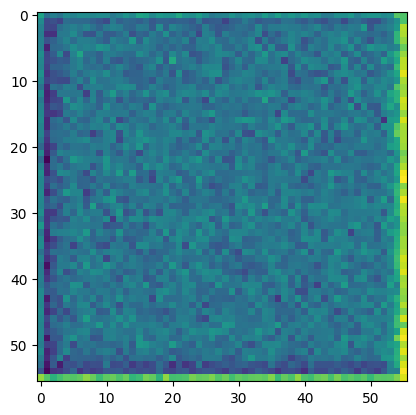

In [159]:
plt.imshow(noise_feature_output.detach().numpy())

In [ ]:
fig, axs = plt.subplots(16, 16, figsize=(20,20))
for i in range(16):
    for j in range(16):
        axs[i][j].imshow(content_feature_output[i*16+j].detach().numpy())

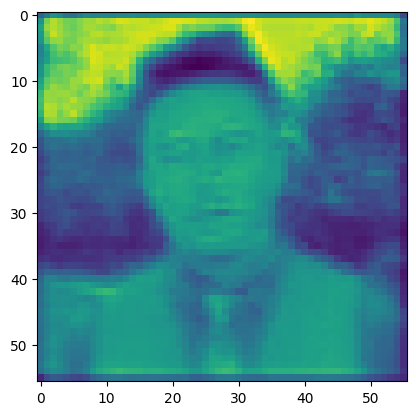

In [227]:
plt.imshow(averaged_fortnite.detach().numpy())

In [243]:
# style replication
style_feature_output = vgg_model.features[:10](style_image)

In [244]:
style_feature_output = style_feature_output.view(128, -1)

In [202]:
torch.norm(style_feature_output)

tensor(79.5379, grad_fn=<LinalgVectorNormBackward0>)

In [203]:
style_feature_output /= torch.norm(style_feature_output)

In [245]:
gram_matrix = (style_feature_output @ style_feature_output.T).detach()

In [205]:
gram_matrix.max()

tensor(0.0839)

In [182]:
lbfgs = torch.optim.LBFGS([noise], lr=1.0)

In [148]:
def closure():
    lbfgs.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:10](noise).view(128, -1)

    noise_gram_matrix = noise_feature_output @ noise_feature_output.T

    style_loss = ((gram_matrix - noise_gram_matrix)**2).sum()
    style_loss.backward()

    return style_loss

In [149]:
while True:
    loss = lbfgs.step(closure)
    print(loss, "                                    ", end="\r")

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


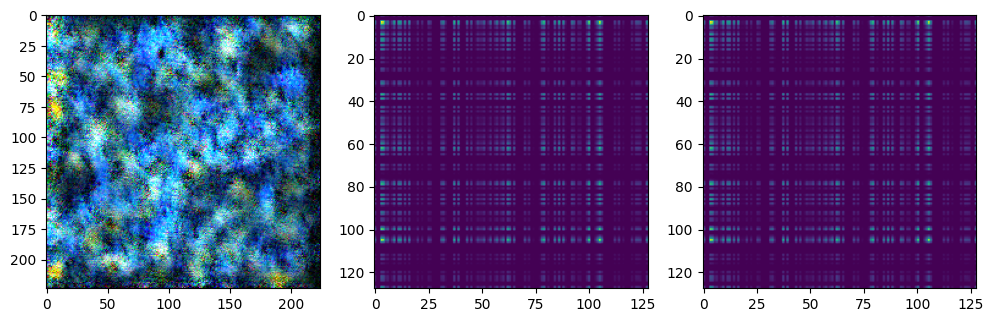

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12))
axs[0].imshow(noise.detach().permute(1,2,0).numpy())
axs[1].imshow(noise_gram_matrix.detach().numpy())
axs[2].imshow(gram_matrix.detach().numpy())

In [246]:
lbfgs = torch.optim.LBFGS([noise], lr=1.0, max_iter=20)

In [247]:
slider = 1.0

In [248]:
# putting it together (style_loss + content_loss)

def closure():
    vgg_model.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:10](noise)
    flattened_noise_feature = noise_feature_output.view(128, -1)

    # flattened_noise_feature /= torch.norm(flattened_noise_feature).detach()
    
    noise_gram_matrix = flattened_noise_feature @ flattened_noise_feature.T

    style_loss = ((gram_matrix - noise_gram_matrix)**2).sum()
    content_loss = ((noise_feature_output - averaged_fortnite)**2).sum()

    total_loss = style_loss * slider + content_loss * (1.0 - slider)

    total_loss.backward()

    return total_loss



In [219]:
adam = torch.optim.Adam([noise], lr=.005)

In [ ]:
# adam optimization
index = 0
while True:
    print(index, closure(), "                                           ", end="\r")
    adam.step()
    index += 1

In [249]:
# lbfgs optimization
while True:
    loss = lbfgs.step(closure)
    print(loss, "                                    ", end="\r")

KeyboardInterrupt: 

d:\PythonLang\Py3-11-2\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


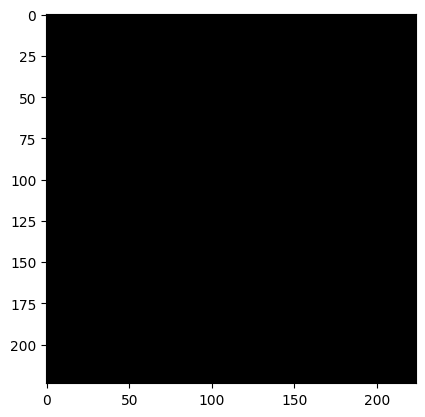

In [250]:
plt.imshow(noise.detach().permute(1,2,0).numpy())
